In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
import scipy.sparse as sp
import torch
import pickle

In [2]:
path = 'data/cold/Youshu/'
ui = pd.read_csv(os.path.join(path, 'user_item.txt'), sep='\t', header=None)
bi = pd.read_csv(os.path.join(path, 'bundle_item.txt'), sep='\t', header=None)
ui.columns = ['user', 'item']
bi.columns = ['bundle', 'item']

ub_train = pd.read_csv(os.path.join(path, 'user_bundle_train.txt'), sep='\t', header=None)
ub_tune = pd.read_csv(os.path.join(path, 'user_bundle_tune.txt'), sep='\t', header=None)
ub_test = pd.read_csv(os.path.join(path, 'user_bundle_test.txt'), sep='\t', header=None)
# ub = pd.concat([ub_train, ub_tune, ub_test], ignore_index=True)
# ub.columns = ['user', 'bundle']
# ub_train.columns = ['user', 'bundle']
# ub_tune.columns = ['user', 'bundle']
# ub_test.columns = ['user', 'bundle']

In [36]:
with open(os.path.join(path, 'bundle_item.txt'), 'r') as f:
    bi_pairs = list(map(lambda s: tuple(int(i) for i in s[:-1].split('\t')), f.readlines()))
        
indices = np.array(bi_pairs, dtype=np.int32)
values = np.ones(len(bi_pairs))
bi_graph = sp.coo_matrix((values, (indices[:, 0], indices[:, 1])), shape=(4771, 32770)).tocsr()

with open(os.path.join(path, 'user_item.txt'), 'r') as f:
    bi_pairs = list(map(lambda s: tuple(int(i) for i in s[:-1].split('\t')), f.readlines()))
        
indices = np.array(bi_pairs, dtype=np.int32)
values = np.ones(len(bi_pairs))
ui_graph = sp.coo_matrix((values, (indices[:, 0], indices[:, 1])), shape=(8039, 32770)).tocsr()

with open(os.path.join(path, 'user_bundle_train.txt'), 'r') as f:
    ub_pairs = list(map(lambda s: tuple(int(i) for i in s[:-1].split('\t')), f.readlines()))
indices = np.array(ub_pairs, dtype=np.int32)
values = np.ones(len(ub_pairs))
ub_train_graph = sp.coo_matrix((values, (indices[:, 0], indices[:, 1])), shape=(8039, 4771)).tocsr()

with open(os.path.join(path, 'user_bundle_tune.txt'), 'r') as f:
    ub_pairs = list(map(lambda s: tuple(int(i) for i in s[:-1].split('\t')), f.readlines()))
indices = np.array(ub_pairs, dtype=np.int32)
values = np.ones(len(ub_pairs))
ub_tune_graph = sp.coo_matrix((values, (indices[:, 0], indices[:, 1])), shape=(8039, 4771)).tocsr()

with open(os.path.join(path, 'user_bundle_test.txt'), 'r') as f:
    ub_pairs = list(map(lambda s: tuple(int(i) for i in s[:-1].split('\t')), f.readlines()))
indices = np.array(ub_pairs, dtype=np.int32)
values = np.ones(len(ub_pairs))
ub_test_graph = sp.coo_matrix((values, (indices[:, 0], indices[:, 1])), shape=(8039, 4771)).tocsr()

In [37]:
i_pop = ui_graph.sum(axis=0).reshape(-1, 1)
u_pop = ub_train_graph.sum(axis=0).reshape(-1, 1)

In [42]:
from collections import Counter

value_counts = Counter(np.array(u_pop).flatten())

In [2]:
value_counts = sorted(value_counts.items(), key=lambda x: x[0])
value_counts

NameError: name 'value_counts' is not defined

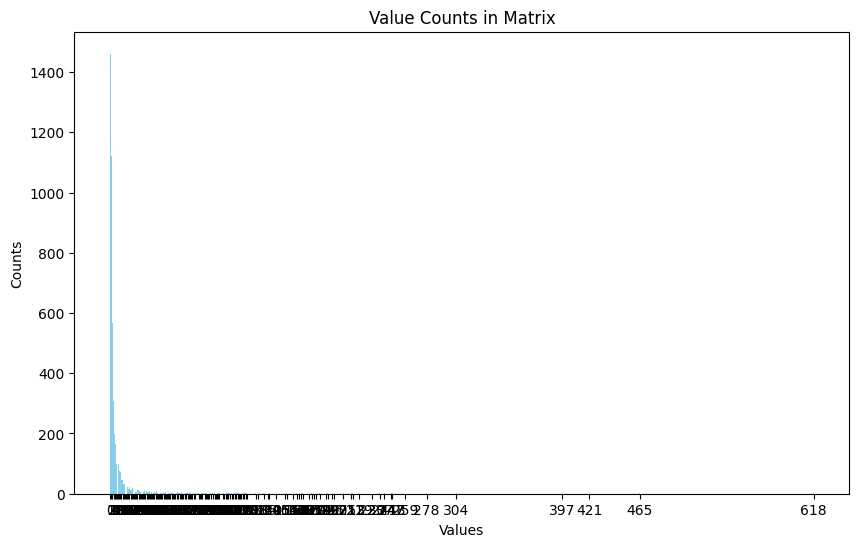

In [43]:
# Extract keys and values from the value counts
values = list(value_counts.keys())
counts = list(value_counts.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(values, counts, color='skyblue')

# Add title and labels
plt.title('Value Counts in Matrix')
plt.xlabel('Values')
plt.ylabel('Counts')

# Display the plot
plt.xticks(values)  # Ensure all values appear on x-axis
plt.show()


In [5]:
def to_tensor(graph):
    """Convert to sparse tensor"""
    graph = graph.tocoo()
    values = graph.data
    indices = np.vstack((graph.row, graph.col))
    graph = torch.sparse_coo_tensor(torch.LongTensor(indices), torch.FloatTensor(values), torch.Size(graph.shape))
    
    return graph

def laplace_transform(graph):
    epsilon = 1e-8
    rowsum_sqrt = sp.diags(1/(np.sqrt(graph.sum(axis=1).A.ravel()) + epsilon))
    colsum_sqrt = sp.diags(1/(np.sqrt(graph.sum(axis=0).A.ravel()) + epsilon))
    graph = rowsum_sqrt @ graph @ colsum_sqrt
    
    return graph

def get_propagation_graph(bipartite_graph, modification_ratio=0):
    device = torch.device('cpu')
    propagation_graph = sp.bmat([[sp.csr_matrix((bipartite_graph.shape[0], bipartite_graph.shape[0])), bipartite_graph], [bipartite_graph.T, sp.csr_matrix((bipartite_graph.shape[1], bipartite_graph.shape[1]))]])
    
    if modification_ratio:
        graph = propagation_graph.tocoo()
        values = np_edge_dropout(graph.data, modification_ratio)
        propagation_graph = sp.coo_matrix((values, (graph.row, graph.col)), shape=graph.shape).tocsr()
    
    return to_tensor(laplace_transform(propagation_graph)).to(device)

# **EDA**

In [73]:
i_ui = set(ui['item'].unique())
i_bi = set(bi['item'].unique())

# Real user-item interactions
item_freq_ui = ui['item'].value_counts()
print("Item frequency in UI view:")
print(item_freq_ui)
print('\n\n')
# Cold-item
cold_item = set(item_freq_ui[item_freq_ui < 5].index)
print("Number of cold-item:", len(cold_item))
# Warm-item
warm_item = set(item_freq_ui[item_freq_ui >= 5].index)
print("Number of warm-item:", len(warm_item))
non_interacted_item = i_bi.difference(i_bi.intersection(i_ui))
print("Number of non-interacted item:", len(non_interacted_item))

print('\n\n')
print("Statistics of item frequency in UI view:")
print(item_freq_ui.describe())

Item frequency in UI view:
16253    778
14647    410
30487    408
23602    407
30693    393
        ... 
28469      1
29226      1
31209      1
18649      1
7676       1
Name: item, Length: 21034, dtype: int64



Number of cold-item: 15864
Number of warm-item: 5170
Number of non-interacted item: 11736



Statistics of item frequency in UI view:
count    21034.000000
mean         6.585290
std         19.441295
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        778.000000
Name: item, dtype: float64


In [74]:
# Real bundle-item interactions
item_freq_bi = bi['item'].value_counts()

print("Item frequency in BI view:")
print(item_freq_bi)

cold_bundle = {}
bi_lvl = {}

for x in bi['bundle'].unique():
    items = bi[bi['bundle'] == x]['item'].tolist()
    bi_lvl[x] = items
    n = len(items)
    if len(set(items).intersection(cold_item)) + len(set(items).intersection(non_interacted_item)) >= n * 0.5:
        cold_bundle[x] = items

print('\n\n')
print("Number of cold-bundle:", len(cold_bundle))
print("Number of warm-bundle:", len(bi['bundle'].unique()) - len(cold_bundle))

print('\n\n')
print("Statistics of item frequency in BI view:")
print(item_freq_bi.describe())

Item frequency in BI view:
17427    394
6109     390
12058    376
16253    353
6740     343
        ... 
16358      1
15370      1
15333      1
14668      1
1796       1
Name: item, Length: 28074, dtype: int64



Number of cold-bundle: 975
Number of warm-bundle: 3796



Statistics of item frequency in BI view:
count    28074.000000
mean         6.292904
std         16.808898
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        394.000000
Name: item, dtype: float64


In [3]:
with open("ui.txt", "r") as f:
    u_i_pairs = list(map(lambda s: tuple(int(i) for i in s[:-1].split()), f.readlines()))

print(u_i_pairs)

[(0, 1), (1, 0), (1, 1), (2, 2), (2, 3), (3, 3), (3, 1), (4, 0)]


In [30]:
indices = np.array(u_i_pairs, dtype=np.int32)
values = np.ones(len(u_i_pairs), dtype=np.float32)
u_i_graph = sp.coo_matrix(
    (values, (indices[:, 0], indices[:, 1])), shape=(5, 4)).tocsr()

In [31]:
item_level_graph = sp.bmat([[sp.csr_matrix((u_i_graph.shape[0], u_i_graph.shape[0])), u_i_graph], [u_i_graph.T, sp.csr_matrix((u_i_graph.shape[1], u_i_graph.shape[1]))]])

In [32]:
item_level_graph.toarray()

array([[0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0.]])

In [33]:
def to_tensor(graph):
    """Convert to sparse tensor"""
    graph = graph.tocoo()
    values = graph.data
    indices = np.vstack((graph.row, graph.col))
    graph = torch.sparse_coo_tensor(torch.LongTensor(indices), torch.FloatTensor(values), torch.Size(graph.shape))
    
    return graph

def get_user_prop_graph( bipartite_graph, modification_ratio=0):
        # device = self.device
        propagation_graph = sp.bmat([[sp.csr_matrix((bipartite_graph.shape[0], bipartite_graph.shape[0])), bipartite_graph], [bipartite_graph.T, sp.csr_matrix((bipartite_graph.shape[1], bipartite_graph.shape[1]))]])
        
        degree = np.array(propagation_graph.sum(axis=1)).squeeze()
        degree = np.maximum(1., degree)
        d_inv = np.power(degree, -0.5)
        d_mat = sp.diags(d_inv, format='csr', dtype=np.float32)
        
        # norm_adj = d_mat.dot(propagation_graph).dot(d_mat)
        norm_adj = d_mat @ propagation_graph @ d_mat
        norm_adj = to_tensor(norm_adj)
        return norm_adj
    
rep= get_user_prop_graph(item_level_graph)

In [34]:
row, col = rep.coalesce().indices()

In [26]:
train_item_result = [
    [0, 1, 2],  # Users 0, 1, 2 interacted with item 0
    [2, 3],     # Users 2, 3 interacted with item 1
    [0, 2, 3],  # Users 0, 2, 3 interacted with item 2
]

In [28]:
ground_truth_pairs = []
for item, rec_user_set in enumerate(train_item_result):
    rec_user_set = [int(u) for u in rec_user_set]
    # rec_map[rec_user_set, item] = 1
    ground_truth_pairs.extend(list(zip(rec_user_set, [item]*len(rec_user_set))))

In [29]:
ground_truth_pairs

[(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (0, 2), (2, 2), (3, 2)]

In [40]:
a = torch.Tensor(u_i_graph.nonzero()[1])

In [45]:
uniques, counts = a.unique(return_counts=True)
values = torch.Tensor([1,2,3,4,5,6,7,8])

In [46]:
reduce = torch.sum
groups = torch.stack([reduce(item) for item in torch.split_with_sizes(values, tuple(counts))])

In [47]:
groups

tensor([ 3., 12.,  6., 15.])

In [50]:
u_i_graph.sum(axis=0).squeeze().T

matrix([[2.],
        [3.],
        [1.],
        [2.]], dtype=float32)